<a href="https://colab.research.google.com/github/WhiteAndBlackFox/LearningPyTorch/blob/FeedForwardNN/Feed_forwardNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feed-forwardNN

### В качестве задачи надо разработать NN обученную на изображениях из torchvision и опознающую как минимум 8 из 10 изображений парвильно.

#### Импортиреум библиотеки

In [30]:
# Импортируем ГЛАВНУЮ библиотеки :D
import torch
from torch import nn, optim
from torch.autograd import Variable
import torch.nn.functional as F

# куда же мы без нашей библитеки библиотеки по работе с математическими функциями :)
import numpy as np

# Либо с картинками
import torchvision
import torchvision.transforms as transforms

# Отображение картинок
import matplotlib.pyplot as plt

#### Сразу определим, если есть видеокарта, то лучше на ней считать иначе на cpu все делаем

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### Начинаем обучать нашу NN

In [51]:
# Сразу нормализируем данные
transformations = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                      ])

In [52]:
# Собираем данные для обучения train=True
train_dataset = torchvision.datasets.CIFAR10(root='data/',
                                             train=True,  
                                             transform=transformations,
                                             download=True)

Files already downloaded and verified


In [48]:
# Смотрим какие у нас картинки - размер и название
image, label = train_dataset[0]
print(image.size())
print(label)

torch.Size([3, 32, 32])
6


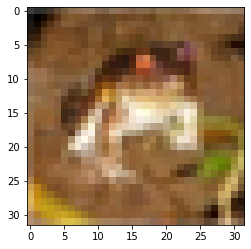

In [7]:
# На картинке лягушка
plt.imshow(image.permute(1, 2, 0).numpy())

In [53]:
# Загружаем данные, для дальнейшего их обучения в тренеровочную сетку
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64, 
                                           shuffle=True)

In [74]:
# проделываем то же самое для тестовых данных train=False
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transformations)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10,
                                         shuffle=False)

Files already downloaded and verified


#### По описанию батча, который находится в библиотеке torchvision - readme.html. Используется сборка CIFAR-10 состоящая из 10 объектов, их и обозначим в отдельный list, для дальнейшего обозначения.

In [15]:
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

### Перед описанием самой нейронной сетки немного разберем то что у нас есть из данных (немного теории)

У нас имеется 10 объектов, в виде картинок. Картинки используют канал RGB (CMYK, Альфа и Grayscale отпадают). Что это значит, то что у каждой картинки есть 3 канала цвета. Это так же подтверждает информация, которую получили выше - torch.Size([3, 32, 32]. Первая цифра у нас показывает сколько каналов у изображения. Чтобы не строить большие входящие параметры, возьмем этот признак за главное (признак 3-х каналов), это значит что входящих каналов будет 3. Исходящих каналов будет 10 - т.к. всего 10 объектов в CIFAR-10.

Т.к. мы берем картинки как данные (цифры), значит определим их сразу в Conv2d, чтобы не переопределять и не обрезать.

Осталось определить скрытые слои и функцию активации...

Честно говоря функция leaky_relu и prelu очень заманчивые сами по себе, но они не привередливые и то что ниже нуля не отсеивают, из-за чего может страдать результат, так что возьмем более строгий вариант relu. 

А раз остановились на relu, значит придется немного поработать с входящими данными, чтобы повысить точность, для этого используем BatchNorm. Раз используем BatchNorm, мы зануляем средние значения, что не очень хорошо и может повлиять на сам батч и захватить лишние признаки у объекта, о которых мы или не знаем или упустили. Чтобы такого не было используем MaxPool. И в конечном итоге используем слои Linear чтобы завершить саму сетку и рассознать наш объект.

Раз определились какие у нас будут функции, количество слоев скрытых будем определять эксперементально.

### Теперь опишем нейронную сетку

In [81]:
class Net(nn.Module):
    __size_inp_lenear = 2400

    def __init__(self):
        super(Net, self).__init__()
        
        self.bn1 = nn.BatchNorm2d(12)
        self.bn2 = nn.BatchNorm2d(12)
        # Пока не пойму, почему но добавление 2-х батчей улучшает нейронную сеть...
        self.bn3 = nn.BatchNorm2d(24)
        self.bn4 = nn.BatchNorm2d(24)

        self.conv1 = nn.Conv2d(3, 12, 5, padding=1)
        self.conv2 = nn.Conv2d(12, 12, 5, padding=1)
        self.conv3 = nn.Conv2d(12, 24, 5, padding=1)
        self.conv4 = nn.Conv2d(24, 24, 5, padding=1)

        self.pool = nn.MaxPool2d(2,2)

        self.fc = nn.Linear(self.__size_inp_lenear, 10)
        

    def forward(self, inputs):
      outputs = self.conv1(inputs)
      outputs = self.bn1(outputs)
      outputs = F.relu(outputs)

      outputs = self.conv2(outputs)
      outputs = self.bn2(outputs)
      outputs = F.relu(outputs)

      outputs = self.pool(outputs)

      outputs = self.conv3(outputs)
      outputs = self.bn3(outputs)
      outputs = F.relu(outputs)

      outputs = self.conv4(outputs)
      outputs = self.bn4(outputs)
      outputs = F.relu(outputs)

      outputs = outputs.view(-1, self.__size_inp_lenear)
      return self.fc(outputs)

### Начнем обучение нейронной сети

In [82]:
net = Net()
# Переключим нашу сеть на обучение и начнем обучать её
net.train()

Net(
  (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(3, 12, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(12, 12, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(12, 24, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(24, 24, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=2400, out_features=10, bias=True)
)

In [83]:
# Функцию потери и оптемизацию используем распространенные функции:
# Функция потери - перекресная интропия
# Оптимизатор - SGD
lost_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.0)

In [84]:
net.to(device=device)

num_epochs = 5

best_accuracy = 0.0

for epoch in range(num_epochs):
  running_lost = 0.0
  running_items = 0.0

  for i, (inputs, labels) in enumerate(train_loader, 0):
    
    # На всякий случай переносим все на ОДНО устройство, чтобы ничего не потерялось!
    inputs = Variable(inputs.to(device))
    labels = Variable(labels.to(device))

    # Зануляем все оптимизатор
    optimizer.zero_grad()
    # Делаем предсказание
    outputs = net(inputs)
    # Проверяем потери
    lost = lost_fn(outputs, labels)
    # Делаем шаг назад по потерям
    lost.backward()
    # Делаем шаг у оптимизатора
    optimizer.step()

    # выводим статистику о процессе обучения
    running_lost += lost.item()
    running_items += len(labels)

    if i % 300 == 0:    # печатаем каждые 300 mini-batches
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {running_lost / running_items:.3f}')
            running_lost, running_items = 0.0, 0.0

print('Training is finished!')

Epoch [1/5]. Step [1/782]. Loss: 0.038
Epoch [1/5]. Step [301/782]. Loss: 0.025
Epoch [1/5]. Step [601/782]. Loss: 0.021
Epoch [2/5]. Step [1/782]. Loss: 0.020
Epoch [2/5]. Step [301/782]. Loss: 0.018
Epoch [2/5]. Step [601/782]. Loss: 0.017
Epoch [3/5]. Step [1/782]. Loss: 0.016
Epoch [3/5]. Step [301/782]. Loss: 0.015
Epoch [3/5]. Step [601/782]. Loss: 0.015
Epoch [4/5]. Step [1/782]. Loss: 0.014
Epoch [4/5]. Step [301/782]. Loss: 0.014
Epoch [4/5]. Step [601/782]. Loss: 0.014
Epoch [5/5]. Step [1/782]. Loss: 0.011
Epoch [5/5]. Step [301/782]. Loss: 0.013
Epoch [5/5]. Step [601/782]. Loss: 0.013
Training is finished!


### Результат
В результате получилася наилучший результат с потерей 0.011. Что же сохраним получившуюся модель.

### Сохранение модели

In [85]:
paths = './cifar_10_feed_forward_nn.pth'
torch.save(net.state_dict(), paths)

### Теперь самое время загрузить и проверить то что получилось на реульных данных

In [86]:
paths = './cifar_10_feed_forward_nn.pth'

net = Net()
net.load_state_dict(torch.load(paths))

<All keys matched successfully>

In [87]:
data_iter = iter(test_loader)
images, labels = data_iter.next()

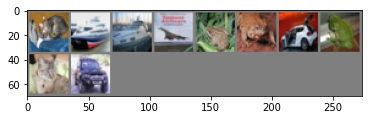

GroundTruth:  cat ship ship airplane frog frog automobile frog cat automobile


In [90]:
net.eval()
outputs = net(images)
img = torchvision.utils.make_grid(images)
img = img / 2 + 0.5
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()

print('GroundTruth: ', ' '.join(classes[labels[j]] for j in range(len(labels))))

In [91]:
_, predicted = torch.max(outputs, 1)

predicted

tensor([3, 1, 8, 0, 6, 6, 1, 6, 3, 1])

In [92]:
gt = np.array([classes[labels[j]] for j in range(len(labels))])
pred = np.array([classes[predicted[j]] for j in range(len(labels))])

print(gt)
print(pred)
print(f'Accuracy is {(gt == pred).sum() / len(gt)}')

['cat' 'ship' 'ship' 'airplane' 'frog' 'frog' 'automobile' 'frog' 'cat'
 'automobile']
['cat' 'automobile' 'ship' 'airplane' 'frog' 'frog' 'automobile' 'frog'
 'cat' 'automobile']
Accuracy is 0.9


### 9 из 10 определилось верно, уже хорошо и пока наилучший вариант.